# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import autokeras as ak
import tensorflow as tf
import pandas as pd

strategyArray  = []
gainArray      = []
lossArray      = []
channelTypeQnt = 3
ampNumber      = 2

originalDataSet = []
binaryDataSet   = []

gainScalerList = []
lossScalerList = []

originalDataSet.append(pd.read_csv('../datasets/1_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/2_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))

for i in range(channelTypeQnt):
    binaryDataSet.append([])
    for line in originalDataSet[i].values:
        myList = [1 if i != 0 else 0 for i in line[:40]]
        myList.extend(line[40:])
        binaryDataSet[i].append(myList)

    binaryDataSet[i] = pd.DataFrame(binaryDataSet[i])
    gainScaler       = MinMaxScaler(feature_range = (-1, 1))
    lossScaler       = MinMaxScaler(feature_range = (-1, 1))

    gainScalerAux = []
    lossScalerAux = []
    
    for j in range(0, ampNumber * 2, 2):
        gainScalerAux.extend(binaryDataSet[i].values[:, 40 + j])
        lossScalerAux.extend(binaryDataSet[i].values[:, 40 + j + 1])

    gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
    lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))
    
    gainScalerList.append(gainScaler)
    lossScalerList.append(lossScaler)

def loadDataset(channelIndex): 
    dataSet = binaryDataSet[channelIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet[channelIndex].values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet[channelIndex].values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    X, y = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    return X, y

def invertGainNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScalerList[channelIndex].inverse_transform(auxArray)[0][0]

def invertLossNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScalerList[channelIndex].inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2, channelIndex):
    return (invertGainNorm(value1, channelIndex) - invertGainNorm(value2, channelIndex))**2

def getLossError(value1, value2, channelIndex):
    return (invertLossNorm(value1, channelIndex) - invertLossNorm(value2, channelIndex))**2

X, y = loadDataset(0)

4


# Cross validation function

In [2]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = math.ceil(X.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i], 0) 
                lossError += getLossError(predicted[i + 1], expected[i + 1], 0)
                 
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, channelIndex):   
    features, result       = loadDataset(channelIndex)
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))
    
    gainArray[channelIndex].append(gainErrors)
    lossArray[channelIndex].append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotErrorBoxPlots():
    fig, axis = plt.subplots(2, 3, figsize = (10, 5))
    
    p1 = axis[0, 0].boxplot(np.sqrt(gainArray[0]))
    axis[0, 0].set_ylabel("Gain error (dB)", fontsize = 8)
    axis[0, 0].set_ylim([1, 8])
    
    axis[0, 1].boxplot(np.sqrt(gainArray[1]))
    axis[0, 1].set_ylim([1, 8])
    
    axis[0, 2].boxplot(np.sqrt(gainArray[2]))
    axis[0, 2].set_ylim([1, 8])
    
    axis[1, 0].boxplot(np.sqrt(lossArray[0]))
    axis[1, 0].set_ylabel("Loss error (dB)", fontsize = 8)
    axis[1, 0].set_xlabel("1 channel type", fontsize = 8)
    axis[1, 0].set_ylim([1, 8])
    
    axis[1, 1].boxplot(np.sqrt(lossArray[1]))
    axis[1, 1].set_xlabel("2 channel type", fontsize = 8)
    axis[1, 1].set_ylim([1, 8])
    #axis[1, 1].get_yaxis().set_visible(False)
    
    axis[1, 2].boxplot(np.sqrt(lossArray[2]))
    axis[1, 2].set_xlabel("4 channel type", fontsize = 8)
    axis[1, 2].set_ylim([1, 8])
    #axis[1, 2].get_yaxis().set_visible(False)
    
    fig.suptitle("Train error", fontsize = 16)
    fig.legend(p1["boxes"], strategyArray, handlelength = 0, bbox_to_anchor=(0.7, 0.81), loc = "right")
    
    #fix scale
    
    plt.show()

In [6]:
def plotGainDistribution(regressor):
    return
    features, result = loadDataset(channelIndex)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0], 0), vFunc(predicted[:, 0], 0))
    axis.set_title("Gain Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor):
    return
    features, result = loadDataset(0)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1], 0), vFunc(predicted[:, 1], 0), c = "m")
    axis.set_title("Loss Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [8]:
gainArray = [[],[],[]]
lossArray = [[],[],[]]

In [9]:
for i in range(channelTypeQnt):
    linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
    trainModel(linearSVR, i)
    
strategyArray.append("1 - SVR (Linear)")
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

4
[27.5226384  12.13466531  7.59926115 15.46541086 21.55823596] => 4.11 (+/- 14.02)
[23.92150745 20.48821373 12.4965803  13.07435474  7.01676495] => 3.92 (+/- 12.09)
4
[17.60908373 11.40958729 17.07447413 17.57095655 12.1113111 ] => 3.89 (+/- 5.57)
[13.92429971 10.83626591  9.9285608   5.58633471  8.41890031] => 3.12 (+/- 5.50)
4
[14.64296501 18.64787084 14.14329551 15.61468977 17.37104247] => 4.01 (+/- 3.38)
[14.86826489 12.43968168  6.54909262 12.1051641   6.31614149] => 3.23 (+/- 6.84)


In [10]:
for i in range(channelTypeQnt):
    lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
    trainModel(lasso, i)
    
strategyArray.append("2 - Lasso")
plotGainDistribution(lasso)
plotLossDistribution(lasso)

4
[26.03571394 17.25208915 10.91741796 15.19942739 22.66498752] => 4.29 (+/- 10.73)
[20.20197944 18.31949626 18.52708619 10.12705604  8.55241174] => 3.89 (+/- 9.62)
4
[19.54329703 14.20760873 21.12012761 16.18957028 23.42939202] => 4.35 (+/- 6.65)
[14.82238191 15.64525056 11.29580787  8.68700019  7.84719505] => 3.41 (+/- 6.29)
4
[16.4036857  19.47117476 16.07094286 19.67655394 19.39735278] => 4.27 (+/- 3.22)
[16.76876336 11.18636833  7.90699814 11.41945597  6.61388104] => 3.28 (+/- 7.05)


In [11]:
for i in range(channelTypeQnt):
    lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
    trainModel(lars, i)
    
strategyArray.append("3 - LARS")
plotGainDistribution(lars)
plotLossDistribution(lars)

4
[27.53534982 16.68482167 10.47942735 14.73360176 25.30175005] => 4.35 (+/- 12.92)
[21.74023486 21.03793523 17.12621223 10.03933023 11.03605392] => 4.02 (+/- 9.78)
4
[19.43932528 14.48469735 19.96563608 15.60932428 24.3292198 ] => 4.33 (+/- 6.99)
[14.14414452 12.38146835 10.42183999  6.97999543  8.87610519] => 3.25 (+/- 5.05)
4
[17.16137111 18.89620983 16.26686895 18.96659847 18.21861535] => 4.23 (+/- 2.09)
[15.8148166  10.9412985   7.69439694 11.9456486   6.46793816] => 3.25 (+/- 6.61)


In [12]:
for i in range(channelTypeQnt):
    huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
    trainModel(huber, i)
    
strategyArray.append("4 - Huber")
plotGainDistribution(huber)
plotLossDistribution(huber)

4
[28.20995519 27.49933909  7.63555947 15.8193632  36.44088832] => 4.81 (+/- 20.31)
[28.35782707 24.59701896 13.12683941 14.8427083   9.126329  ] => 4.24 (+/- 14.51)
4
[17.05036823 57.48619835 19.26009511 17.36308943 16.54409129] => 5.05 (+/- 32.00)
[18.93414262 12.97489131 10.05324845  5.68984128 11.72648908] => 3.45 (+/- 8.61)
4
[44.47945143 18.94181804 52.66276976 21.55496547 23.13767441] => 5.67 (+/- 27.43)
[26.30938747 13.2388671  26.30247155 20.11385211 13.669267  ] => 4.46 (+/- 11.50)


In [13]:
for i in range(channelTypeQnt):
    knn = MultiOutputRegressor(KNeighborsRegressor())
    trainModel(knn, i)
    
strategyArray.append("5 - KNN")
plotGainDistribution(knn)
plotLossDistribution(knn)

4
[60.12440945 18.08031496  8.2784252  13.74204724 31.91496063] => 5.14 (+/- 37.15)
[12.83181102 26.66110236 10.53291339 10.40755906  6.26299213] => 3.65 (+/- 13.98)
4
[18.48151724 35.36193103 16.392      19.69917241 12.01296552] => 4.52 (+/- 15.86)
[20.23931034 18.86882759 10.09006897  5.94303448  9.15062069] => 3.59 (+/- 11.31)
4
[20.78929062 19.53656751 18.49675057 21.43286041 25.9197254 ] => 4.61 (+/- 5.10)
[13.20320366 12.98617849  8.36951945 11.80924485  8.1175286 ] => 3.30 (+/- 4.44)


In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

for i in range(channelTypeQnt):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
    bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
    trainModel(bret, i)
    
strategyArray.append("6 - Extra Tree")
plotGainDistribution(bret)
plotLossDistribution(bret)

4
[34.10655459 16.42489795  7.62774458 13.38500357 33.05207056] => 4.57 (+/- 21.44)
[28.73650647 23.78127176 12.57486885 14.03911878  9.36287229] => 4.21 (+/- 14.64)
4
[16.72409711 14.87003927 18.45141325 16.56475792 10.03881109] => 3.92 (+/- 5.76)
[16.28892073 10.33882126  9.66034272  5.52804552  8.32077736] => 3.17 (+/- 7.08)
4
[20.04343764 19.95875787 13.55347306 13.79117967 16.99177276] => 4.11 (+/- 5.66)
[13.93741255 12.56302245  6.36111374 11.36859482  7.79011782] => 3.23 (+/- 5.74)


In [15]:
from sklearn.ensemble import RandomForestRegressor

for i in range(channelTypeQnt):
    randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
    trainModel(randomForest, i)

strategyArray.append("7 - Random Forest")
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

4
[34.10655459 16.59308689  7.62774458 13.41025703 33.05207056] => 4.58 (+/- 21.41)
[28.73650647 23.59873154 12.57486885 14.16693085  9.36287229] => 4.21 (+/- 14.56)
4
[16.78546472 14.31846442 19.01064712 16.07799676 10.4861161 ] => 3.92 (+/- 5.71)
[13.74229856 10.38824761  9.52515258  5.52571046  8.31660528] => 3.08 (+/- 5.37)
4
[24.3677857  20.38281623 13.51269284 13.992725   18.44251436] => 4.26 (+/- 8.12)
[15.11681463 13.30810211  6.38169423 11.2441357   7.06729191] => 3.26 (+/- 6.84)


# Plotting error boxplots

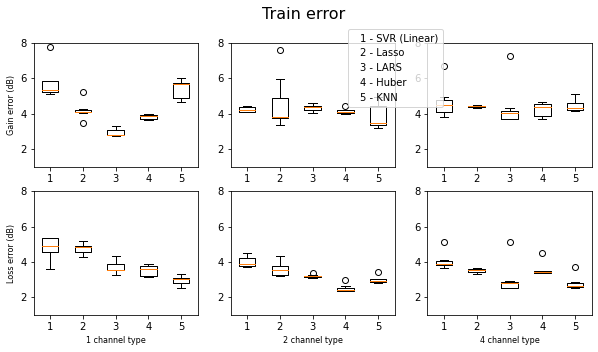

In [16]:
plotErrorBoxPlots()